In [34]:
# import library
import pandas as pd
import re
import tensorflow as tf

df = pd.read_csv('KRvideos_modi_fin.csv',encoding = 'cp949')
df.head()

,category_id,publish_time,likes,dislikes,comment_count,views
0,10,2017-02-20,528,1,12,20984
1,10,2017-02-20,690,6,29,36233
2,10,2017-02-20,699,6,29,36843
3,26,2017-06-07,6,0,2,14178
4,26,2017-06-07,6,0,2,14210


In [35]:
# datatimed으로 'publish_time'변경하기
#1. type object--> str변경
#2. 날짜 사이 하이픈'-'삭제
#3. numerical로 int64로 만들기
#4. datetime포맷으로 변경하기.

df.publish_time = df.publish_time.apply(lambda x: str(x))
df.publish_time = df.publish_time.apply(lambda x: re.sub('-','',x))
df.publish_time = pd.to_numeric(df.publish_time)
#4. 
pd.to_datetime(df['publish_time'], format='%Y%m%d')

df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y%m%d')
df['연도']=df['publish_time'].dt.year
df['월'] =df['publish_time'].dt.month
df['일']= df['publish_time'].dt.day

In [36]:
# Common imports
import numpy as np
import os
from pathlib import Path
import seaborn as sns
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


Text(0, 0.5, 'views')

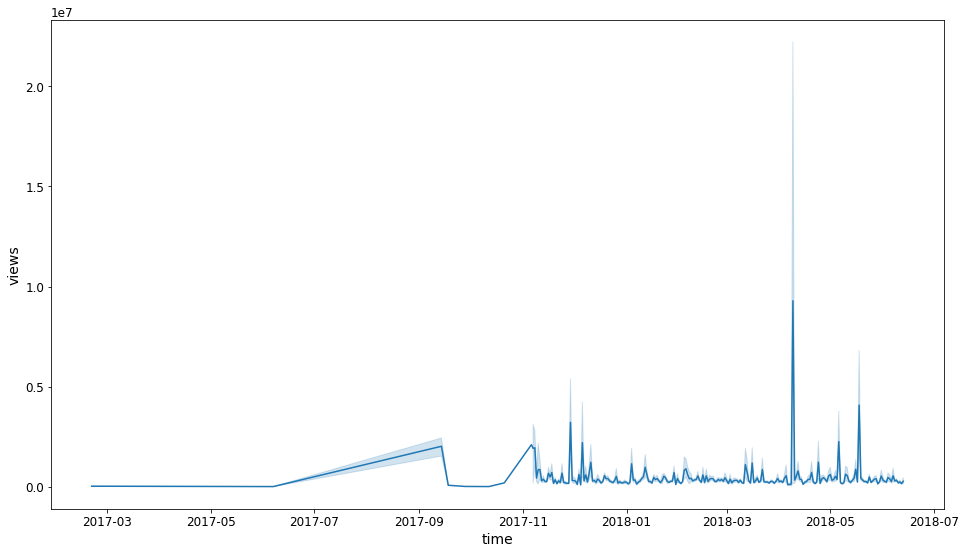

In [37]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['views'], x=df['publish_time']) # 2017년도만 보여주기.
plt.xlabel('time')
plt.ylabel('views')

#Normalization


In [38]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['category_id',	'views',	'likes',	'dislikes',	'comment_count']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

       category_id     views     likes      dislikes  comment_count
0         0.209302  0.000166  0.000103  6.800926e-07       0.000011
1         0.209302  0.000300  0.000134  4.080556e-06       0.000025
2         0.209302  0.000306  0.000136  4.080556e-06       0.000025
3         0.581395  0.000107  0.000001  0.000000e+00       0.000002
4         0.581395  0.000107  0.000001  0.000000e+00       0.000002
...            ...       ...       ...           ...            ...
34548     0.558140  0.000247  0.000363  6.188843e-05       0.000034
34549     0.534884  0.000696  0.000062  1.156157e-05       0.000053
34550     0.441860  0.000605  0.000743  1.632222e-05       0.000804
34551     0.558140  0.003786  0.000000  0.000000e+00       0.000153
34552     0.558140  0.009654  0.000788  1.178600e-03       0.006813

[34553 rows x 5 columns]


In [39]:
#test_size = 200 --> 과거로부터 200일 이전의 데이터를 학습하도록 한다. 
test_size = 300
train = df_scaled[:-test_size]
test = df_scaled[-test_size:]

# dataset 생성 함수 정의.
# 이때, window_size: 내가 얼마동안(기간)의 조회수 데이터에 기반해 다음날 조회수를 예측할 것인가를 정하는 parameter.

def make_dataset(data, label, window_size=30):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

#feature 와 label 정의

In [40]:
## 경로 지정
model_path = '/content/drive/My Drive/Colab Notebooks'

feature_cols = ['dislikes','likes',	'comment_count']
label_cols = ['views'] # target attribute

train_feature = train[feature_cols]
train_label = train[label_cols]

test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 30)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
#(object개수, time_step, feature개수)
# ((27458, 30, 4), (6865, 30, 4))



((27378, 30, 3), (6845, 30, 3))

In [41]:
test_feature, test_label = make_dataset(test_feature, test_label, 30)
test_feature.shape, test_label.shape
#((170, 30, 4), (170, 1))

((270, 30, 3), (270, 1))

In [42]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
# Found GPU at: /device:GPU:0

Found GPU at: /device:GPU:0


#Keras를 활용한 LSTM모델 생성

In [43]:
#Keras를 활용한 LSTM모델 생성
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
# 이전것 모두 tf.으로 바꿔주기
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

## GPU사용하기
with tf.device('/device:GPU:0'):
  model = Sequential()
  model.add(layers.LSTM(20, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False))
  model.add(layers.Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy']) # val_loss not improve 해결 위해 optimizer 'adam' --> 'sgd'로 변경함. 
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  filename = os.path.join(model_path, 'tmp_checkpoint.h5')
  checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto') # mode- auto 는 min, max default로 결정함. 

  history = model.fit(x_train, y_train, 
                    epochs=100,  # 일단 10번만 test로 돌리고, 200회하자. 
                    batch_size=64,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
428/428 [==============================] - 20s 46ms/step - loss: 5.0844e-04 - accuracy: 1.5002e-05 - val_loss: 3.5923e-04 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.00036, saving model to /content/drive/My Drive/Colab Notebooks/tmp_checkpoint.h5
Epoch 2/100
428/428 [==============================] - 20s 46ms/step - loss: 4.0287e-04 - accuracy: 1.6305e-05 - val_loss: 3.1390e-04 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.00036 to 0.00031, saving model to /content/drive/My Drive/Colab Notebooks/tmp_checkpoint.h5
Epoch 3/100
428/428 [==============================] - 19s 45ms/step - loss: 3.0810e-04 - accuracy: 1.5596e-06 - val_loss: 2.8876e-04 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss improved from 0.00031 to 0.00029, saving model to /content/drive/My Drive/Colab Notebooks/tmp_checkpoint.h5
Epoch 4/100
428/428 [==============================] - 19s 45ms/step - loss: 2.7235e-04 - accuracy: 3.9676e-05 - val_loss: 2.893

In [44]:
# 예측
pred = model.predict(test_feature)

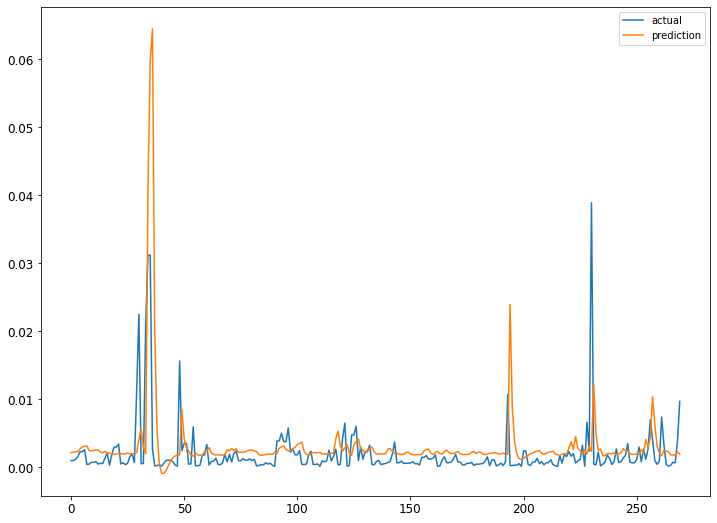

In [45]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

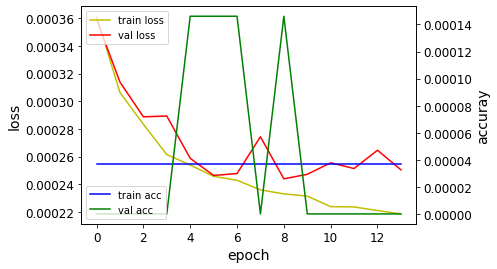

In [46]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [47]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [48]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
valScore = model.evaluate(x_valid, y_valid, verbose=0)
print('Validataion Score: ', valScore)


Train Score:  [0.00020865276746917516, 3.652567829703912e-05]
Validataion Score:  [0.00025040507898665965, 0.0]


In [49]:

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_train, y_train, batch_size=32)
print("val loss, val acc:", results)

Evaluate on test data
856/856 [==============================] - 4s 5ms/step - loss: 2.0865e-04 - accuracy: 3.6526e-05
val loss, val acc: [0.00020865276746917516, 3.652567829703912e-05]
